### Import libraries

In [1]:
import astropy.io.fits as pyfits

import os
import pickle
import numpy as np
#from scipy.misc import imresize
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics

Using TensorFlow backend.


### Load labels file

In [3]:
label_file = "R_filtrid/BD_decomp_asi.txt"
galaxies_info = pd.read_table(label_file,header=None,index_col=False,skiprows=1)
part1 = galaxies_info.loc[galaxies_info[1].isnull(),[0,2,3,4,5,6]]
part1.columns = ["cnr","kval","varb","dust","popul","rescale"]
part2 = galaxies_info.loc[galaxies_info[1].notnull(),[0,1,2,3,4,5]]
part2.columns = ["cnr","kval","varb","dust","popul","rescale"]
galaxies_info = part1.append(part2)
galaxies_info.head()

,cnr,kval,varb,dust,popul,rescale
0,105,2.0,0,T,T,F
1,106,1.0,1,F,F,F
2,107,2.0,0.2,F,T,F
3,108,1.5,0,F,T,F
4,113,2.0,0,F,T,F


In [4]:
labels = np.array(galaxies_info['kval'])
labels = np.repeat(labels,4)
labels[:10]

array([ 2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.])

### Load cropped and flipped data

In [5]:
cropped_galaxies = pickle.load( open( "cropped_galaxies_v2.p", "rb" ) )
cropped_galaxies = sum(cropped_galaxies, [])
cropped_galaxies[0]

array([[ 0.28743659,  0.31731881,  0.31740582, ...,  0.32158645,
         0.33439591,  0.31655157],
       [ 0.28584333,  0.30833318,  0.32378339, ...,  0.3110252 ,
         0.3126021 ,  0.28908759],
       [ 0.2826455 ,  0.31806372,  0.29695156, ...,  0.3313626 ,
         0.30941002,  0.31043061],
       ..., 
       [ 0.33513245,  0.32023974,  0.28570095, ...,  0.32288427,
         0.31685735,  0.32362257],
       [ 0.31517595,  0.32935965,  0.307414  , ...,  0.28892752,
         0.3058944 ,  0.27386654],
       [ 0.31395298,  0.31304476,  0.30242409, ...,  0.30491832,
         0.30746431,  0.31616665]])

Add extra dimension (NxM -> NxMx1) for the correct work of NN

In [6]:
galaxies = []
for arr in cropped_galaxies:    
    galaxies.append(arr[:, :, np.newaxis])
galaxies_array = np.array(galaxies)
galaxies_array.min(),galaxies_array.max()

(0.011286736162676605, 0.9995468612060141)

### Make a train/test data split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(galaxies_array, labels, test_size=0.2, random_state=2)

### Define the model architecture

In [8]:
im_size = 100
batch_size = 32

In [9]:
# We first need to define the sequence of dependencies (the computational graph)
x = Input(shape=(im_size, im_size, 1))
h = Conv2D(96, (8, 8))(x)
h = Activation('relu')(h)
h = MaxPooling2D(pool_size = (3, 3))(h)
h = Flatten()(h)
h = Dense(24)(h)
h = Activation('relu')(h)
p = Dense(1)(h)

# Now that we have defined how to find p from x, we can create a 
# model simply by saying what is input and what is output
model = Model(inputs=x, outputs=p)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.00001), 
              metrics=[metrics.mean_squared_error, metrics.mean_absolute_error])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 96)        6240      
_________________________________________________________________
activation_1 (Activation)    (None, 93, 93, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92256)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2214168   
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
__________

Fit and evaluate the model

In [10]:
history = model.fit(X_train, y_train,
          epochs=30,
          batch_size=batch_size,
          validation_split=0.2)

Train on 1827 samples, validate on 457 samples
Epoch 1/30
1827/1827 [==============================] - 162s 89ms/step - loss: 0.9221 - mean_squared_error: 0.9221 - mean_absolute_error: 0.8029 - val_loss: 0.4847 - val_mean_squared_error: 0.4847 - val_mean_absolute_error: 0.5662
Epoch 2/30
1827/1827 [==============================] - 146s 80ms/step - loss: 0.4838 - mean_squared_error: 0.4838 - mean_absolute_error: 0.5569 - val_loss: 0.4559 - val_mean_squared_error: 0.4559 - val_mean_absolute_error: 0.5479
Epoch 3/30
1827/1827 [==============================] - 134s 73ms/step - loss: 0.4535 - mean_squared_error: 0.4535 - mean_absolute_error: 0.5347 - val_loss: 0.4250 - val_mean_squared_error: 0.4250 - val_mean_absolute_error: 0.5270
Epoch 4/30
1827/1827 [==============================] - 123s 67ms/step - loss: 0.4154 - mean_squared_error: 0.4154 - mean_absolute_error: 0.5134 - val_loss: 0.3768 - val_mean_squared_error: 0.3768 - val_mean_absolute_error: 0.4906
Epoch 5/30
1827/1827 [=======

In [9]:
def Make_history_plots(history):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean_squared_error')
    plt.ylabel('mean_squared_error')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'])

    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

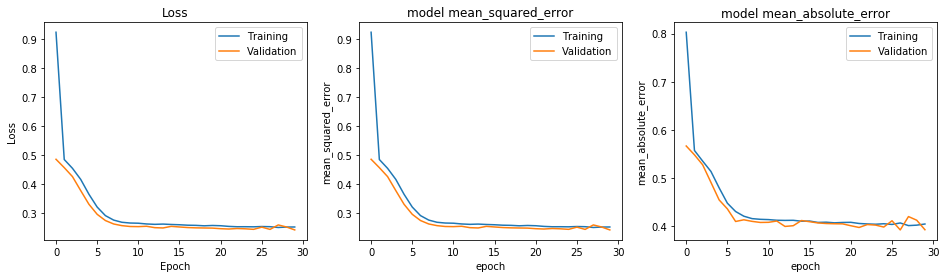

In [16]:
Make_history_plots(history)

In [12]:
model.evaluate(X_train, y_train)

2284/2284 [==============================] - 45s 20ms/step


[0.2471998723814241, 0.2471998723814241, 0.39466691899216111]

In [13]:
model.evaluate(X_test, y_test)

572/572 [==============================] - 13s 23ms/step


[0.27145562128170386, 0.27145562128170386, 0.40977675723029183]

Save model

In [17]:
model.save('original_architecture.h5')

### Try optimizing MAE

In [18]:
model = Model(inputs=x, outputs=p)
model.compile(loss=metrics.mean_absolute_error, 
              optimizer=Adam(lr=0.00001), 
              metrics=[metrics.mean_squared_error, metrics.mean_absolute_error])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 96)        6240      
_________________________________________________________________
activation_1 (Activation)    (None, 93, 93, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92256)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2214168   
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
__________

In [19]:
history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=batch_size,
          validation_split=0.2)

Train on 1827 samples, validate on 457 samples
Epoch 1/10
1827/1827 [==============================] - 123s 67ms/step - loss: 0.3964 - mean_squared_error: 0.2601 - mean_absolute_error: 0.3964 - val_loss: 0.3969 - val_mean_squared_error: 0.2728 - val_mean_absolute_error: 0.3969
Epoch 2/10
1827/1827 [==============================] - 127s 70ms/step - loss: 0.3988 - mean_squared_error: 0.2585 - mean_absolute_error: 0.3988 - val_loss: 0.3890 - val_mean_squared_error: 0.2438 - val_mean_absolute_error: 0.3890
Epoch 3/10
1827/1827 [==============================] - 120s 66ms/step - loss: 0.3947 - mean_squared_error: 0.2583 - mean_absolute_error: 0.3947 - val_loss: 0.3918 - val_mean_squared_error: 0.2412 - val_mean_absolute_error: 0.3918
Epoch 4/10
1827/1827 [==============================] - 135s 74ms/step - loss: 0.3948 - mean_squared_error: 0.2608 - mean_absolute_error: 0.3948 - val_loss: 0.3885 - val_mean_squared_error: 0.2490 - val_mean_absolute_error: 0.3885
Epoch 5/10
1827/1827 [=======

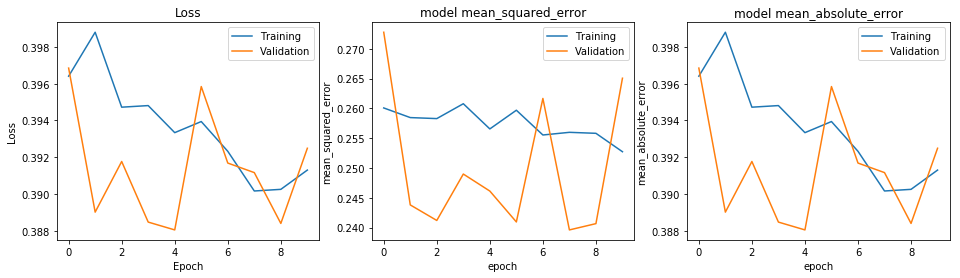

In [20]:
Make_history_plots(history)

In [21]:
model.evaluate(X_train, y_train)

2284/2284 [==============================] - 48s 21ms/step


[0.3950893002612787, 0.27546855342784821, 0.3950893002612787]

In [22]:
model.evaluate(X_test, y_test)

572/572 [==============================] - 13s 23ms/step


[0.41787375728567161, 0.306888985258716, 0.41787375728567161]

In [23]:
model.save('original_architecture_mae-opt.h5')

In [26]:
pred = model.predict(X_test)
print(np.min(pred),np.max(pred))

1.29278 2.10269


(array([  9.,  17.,  41.,  35.,  54.,  60.,  66.,  66.,  38.,  39.,  29.,
         23.,  18.,  17.,  21.,  13.,  12.,   8.,   4.,   2.]),
 array([ 1.29277503,  1.3332707 ,  1.37376636,  1.41426203,  1.45475769,
         1.49525335,  1.53574902,  1.57624468,  1.61674035,  1.65723601,
         1.69773167,  1.73822734,  1.778723  ,  1.81921867,  1.85971433,
         1.90020999,  1.94070566,  1.98120132,  2.02169698,  2.06219265,
         2.10268831]),
 <a list of 20 Patch objects>)

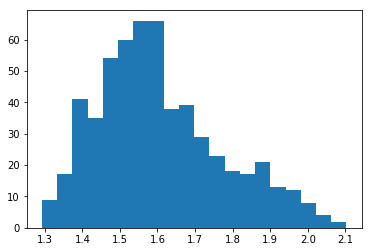

In [25]:
plt.hist(pred,bins=20)

### Add dropout

In [29]:
x = Input(shape=(im_size, im_size, 1))
h = Conv2D(96, (8, 8))(x)
h = Activation('relu')(h)
h = MaxPooling2D(pool_size = (3, 3))(h)
h = Dropout(rate=0.25)(h)
h = Flatten()(h)
h = Dense(24)(h)
h = Activation('relu')(h)
h = Dropout(rate=0.5)(h)
p = Dense(1)(h)

# Now that we have defined how to find p from x, we can create a 
# model simply by saying what is input and what is output
model = Model(inputs=x, outputs=p)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.00001), 
              metrics=[metrics.mean_squared_error, metrics.mean_absolute_error])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 93, 93, 96)        6240      
_________________________________________________________________
activation_4 (Activation)    (None, 93, 93, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 96)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 92256)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2214168   
__________

In [30]:
history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=batch_size,
          validation_split=0.2)

Train on 1827 samples, validate on 457 samples
Epoch 1/10
1827/1827 [==============================] - 151s 83ms/step - loss: 1.1388 - mean_squared_error: 1.1388 - mean_absolute_error: 0.9115 - val_loss: 0.5086 - val_mean_squared_error: 0.5086 - val_mean_absolute_error: 0.5868
Epoch 2/10
1827/1827 [==============================] - 120s 66ms/step - loss: 0.7571 - mean_squared_error: 0.7571 - mean_absolute_error: 0.7218 - val_loss: 0.5270 - val_mean_squared_error: 0.5270 - val_mean_absolute_error: 0.6043
Epoch 3/10
1827/1827 [==============================] - 155s 85ms/step - loss: 0.7409 - mean_squared_error: 0.7409 - mean_absolute_error: 0.7146 - val_loss: 0.4995 - val_mean_squared_error: 0.4995 - val_mean_absolute_error: 0.5876
Epoch 4/10
1827/1827 [==============================] - 151s 83ms/step - loss: 0.6969 - mean_squared_error: 0.6969 - mean_absolute_error: 0.6837 - val_loss: 0.4428 - val_mean_squared_error: 0.4428 - val_mean_absolute_error: 0.5463
Epoch 5/10
1827/1827 [=======

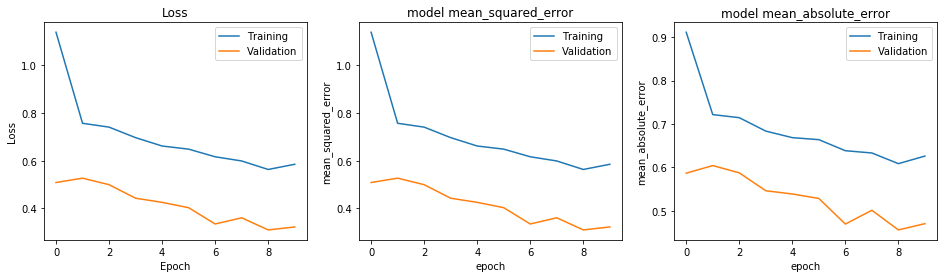

572/572 [==============================] - 14s 25ms/step


In [31]:
Make_history_plots(history)
model.save('add_dropout.h5')

In [33]:
model.evaluate(X_train, y_train)

2284/2284 [==============================] - 48s 21ms/step


[0.31887412008596178, 0.31887412008596178, 0.46974079506618549]

In [34]:
model.evaluate(X_test, y_test)

572/572 [==============================] - 11s 20ms/step


[0.326579062880336, 0.326579062880336, 0.47122036264492917]

0.837415 1.58608


(array([  3.,   8.,  15.,  21.,  32.,  35.,  40.,  58.,  52.,  45.,  47.,
         50.,  38.,  23.,  29.,  23.,  18.,  14.,  10.,  11.]),
 array([ 0.83741504,  0.87484818,  0.91228132,  0.94971446,  0.98714759,
         1.02458073,  1.06201387,  1.09944701,  1.13688015,  1.17431329,
         1.21174642,  1.24917956,  1.2866127 ,  1.32404584,  1.36147898,
         1.39891212,  1.43634526,  1.47377839,  1.51121153,  1.54864467,
         1.58607781]),
 <a list of 20 Patch objects>)

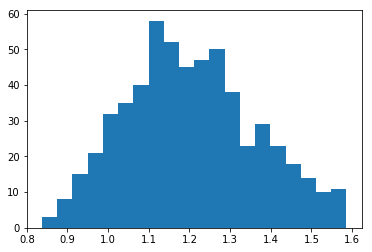

In [32]:
pred = model.predict(X_test)
print(np.min(pred),np.max(pred))
plt.hist(pred,bins=20)

### Add BatchNormalization

In [17]:
x = Input(shape=(im_size, im_size, 1))
h = Conv2D(96, (8, 8))(x)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = MaxPooling2D(pool_size = (3, 3))(h)
#h = Dropout(rate=0.25)(h)
h = Flatten()(h)
h = Dense(24)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
#h = Dropout(rate=0.5)(h)
p = Dense(1)(h)

# Now that we have defined how to find p from x, we can create a 
# model simply by saying what is input and what is output
model = Model(inputs=x, outputs=p)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.00001), 
              metrics=[metrics.mean_squared_error, metrics.mean_absolute_error])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 96)        6240      
_________________________________________________________________
batch_normalization_3 (Batch (None, 93, 93, 96)        384       
_________________________________________________________________
activation_3 (Activation)    (None, 93, 93, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 92256)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2214168   
__________

In [18]:
X_train_norm = (X_train-X_train.mean(axis=(0,1,2)))/X_train.std(axis=(0,1,2))
history = model.fit(X_train_norm, y_train,
          epochs=10,
          batch_size=batch_size,
          validation_split=0.2)

Train on 1827 samples, validate on 457 samples
Epoch 1/10
1827/1827 [==============================] - 586s 321ms/step - loss: 2.6123 - mean_squared_error: 2.6123 - mean_absolute_error: 1.5002 - val_loss: 3.0195 - val_mean_squared_error: 3.0195 - val_mean_absolute_error: 1.6051
Epoch 2/10
1827/1827 [==============================] - 632s 346ms/step - loss: 2.2917 - mean_squared_error: 2.2917 - mean_absolute_error: 1.4027 - val_loss: 2.8077 - val_mean_squared_error: 2.8077 - val_mean_absolute_error: 1.5704
Epoch 3/10
1827/1827 [==============================] - 663s 363ms/step - loss: 2.0960 - mean_squared_error: 2.0960 - mean_absolute_error: 1.3380 - val_loss: 3.0780 - val_mean_squared_error: 3.0780 - val_mean_absolute_error: 1.6142
Epoch 4/10
1827/1827 [==============================] - 579s 317ms/step - loss: 1.9066 - mean_squared_error: 1.9066 - mean_absolute_error: 1.2677 - val_loss: 2.6151 - val_mean_squared_error: 2.6151 - val_mean_absolute_error: 1.5096
Epoch 5/10
1827/1827 [===

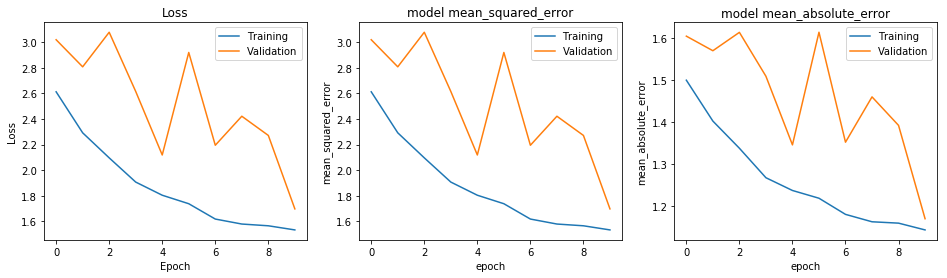

In [19]:
Make_history_plots(history)
model.save('add_batchnorm.h5')

In [20]:
model.evaluate(X_train_norm, y_train)

2284/2284 [==============================] - 289s 126ms/step


[1.5625833204038924, 1.5625833204038924, 1.1261580130264763]

In [23]:
X_test_norm = (X_test-X_test.mean(axis=(0,1,2)))/X_test.std(axis=(0,1,2))
model.evaluate(X_test_norm, y_test)

572/572 [==============================] - 72s 126ms/step


[1.6143163667692171, 1.6143163667692171, 1.1327594543670441]

-1.49522 1.99832


(array([  1.,   0.,   0.,   3.,   9.,  11.,  38.,  67.,  72.,  78.,  47.,
         45.,  56.,  55.,  40.,  25.,  15.,   5.,   4.,   1.]),
 array([-1.49522197, -1.32054505, -1.14586813, -0.97119122, -0.7965143 ,
        -0.62183738, -0.44716046, -0.27248354, -0.09780662,  0.0768703 ,
         0.25154722,  0.42622414,  0.60090106,  0.77557797,  0.95025489,
         1.12493181,  1.29960873,  1.47428565,  1.64896257,  1.82363949,
         1.99831641]),
 <a list of 20 Patch objects>)

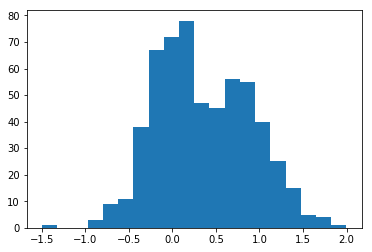

In [24]:
pred = model.predict(X_test_norm)
print(np.min(pred),np.max(pred))
plt.hist(pred,bins=20)

### Try another architecture

In [9]:
x = Input(shape=(im_size, im_size, 1))
h = Conv2D(96, (8, 8))(x)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Conv2D(96, (8, 8))(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = MaxPooling2D(pool_size = (3, 3))(h)
#h = Dropout(rate=0.25)(h)
h = Flatten()(h)
h = Dense(24)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
#h = Dropout(rate=0.5)(h)
p = Dense(1)(h)

# Now that we have defined how to find p from x, we can create a 
# model simply by saying what is input and what is output
model = Model(inputs=x, outputs=p)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.00001), 
              metrics=[metrics.mean_squared_error, metrics.mean_absolute_error])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 96)        6240      
_________________________________________________________________
activation_1 (Activation)    (None, 93, 93, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 96)        589920    
_________________________________________________________________
activation_2 (Activation)    (None, 86, 86, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 75264)             0         
__________

In [10]:
history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=batch_size,
          validation_split=0.2)

Train on 1827 samples, validate on 457 samples
Epoch 1/10
1827/1827 [==============================] - 4359s 2s/step - loss: 0.8142 - mean_squared_error: 0.8142 - mean_absolute_error: 0.7390 - val_loss: 0.4637 - val_mean_squared_error: 0.4637 - val_mean_absolute_error: 0.5529
Epoch 2/10
1827/1827 [==============================] - 4311s 2s/step - loss: 0.4539 - mean_squared_error: 0.4539 - mean_absolute_error: 0.5363 - val_loss: 0.4193 - val_mean_squared_error: 0.4193 - val_mean_absolute_error: 0.5210
Epoch 3/10
1827/1827 [==============================] - 4155s 2s/step - loss: 0.4004 - mean_squared_error: 0.4004 - mean_absolute_error: 0.5007 - val_loss: 0.3785 - val_mean_squared_error: 0.3785 - val_mean_absolute_error: 0.4997
Epoch 4/10
1827/1827 [==============================] - 3942s 2s/step - loss: 0.3325 - mean_squared_error: 0.3325 - mean_absolute_error: 0.4584 - val_loss: 0.2924 - val_mean_squared_error: 0.2924 - val_mean_absolute_error: 0.4202
Epoch 5/10
1827/1827 [===========

In [11]:
Make_history_plots(history)
model.save('add_conv_layer.h5')

NameError: name 'Make_history_plots' is not defined

In [ ]:
model.evaluate(X_train, y_train)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
pred = model.predict(X_test)
print(np.min(pred),np.max(pred))
plt.hist(pred,bins=20)

## Lets try data augmentation

In [17]:
#Re-init the model
model = Model(inputs=x, outputs=p)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 96)        6240      
_________________________________________________________________
activation_1 (Activation)    (None, 93, 93, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92256)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2214168   
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
__________

Define augmentation rules

In [18]:
datagen_train = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    rotation_range=20,
    width_shift_range=0.5,
    height_shift_range=0.5,
    zoom_range = 0.5,
    fill_mode = 'constant',
    vertical_flip = True,
    horizontal_flip=True)
datagen_test = datagen_train

Make train/validation/test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(galaxies_array, labels, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [20]:
datagen_train.fit(X_train)
datagen_test.fit(X_test)

Train the model on augmented data

In [21]:
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train)/batch_size, epochs = 30,
                    validation_data = datagen_test.flow(X_val, y_val, batch_size = batch_size),
                    validation_steps = len(X_val)/batch_size)

Epoch 1/30
61/60 [==============================] - 161s 3s/step - loss: 12.9566 - acc: 0.1873 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 2/30
61/60 [==============================] - 191s 3s/step - loss: 12.9566 - acc: 0.1873 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 3/30
61/60 [==============================] - 148s 2s/step - loss: 12.9482 - acc: 0.1878 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 4/30
61/60 [==============================] - 144s 2s/step - loss: 12.9566 - acc: 0.1873 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 5/30
61/60 [==============================] - 147s 2s/step - loss: 12.9566 - acc: 0.1873 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 6/30
61/60 [==============================] - 144s 2s/step - loss: 12.9566 - acc: 0.1873 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 7/30
61/60 [==============================] - 145s 2s/step - loss: 12.9650 - acc: 0.1868 - val_loss: 13.3181 - val_acc: 0.1646
Epoch 8/30
61/60 [==============================] - 144s 2s/step - lo

KeyboardInterrupt: 

Test accuracy 0.796296296296
Confusion matrix
[[86  0]
 [22  0]]


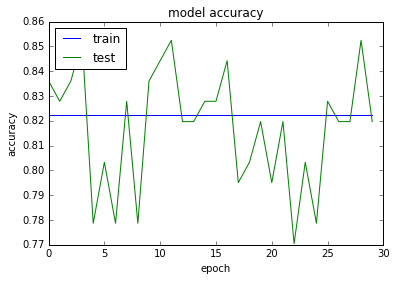

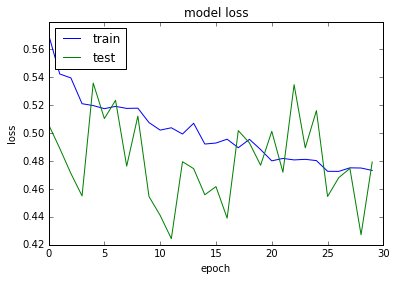

In [82]:
Model_evaluate(model,X_test,y_test,batch_size,history)

## Lets try augmentation and class weights

In [83]:
#Re-init the model
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 121, 121, 96)      6240      
_________________________________________________________________
activation_10 (Activation)   (None, 121, 121, 96)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 96)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                3686424   
_________________________________________________________________
activation_11 (Activation)   (None, 24)                0         
__________

In [84]:
class_weight = {0 : 1., 1: len(labels)/sum(labels)}
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train)/batch_size, epochs = 30,
                    validation_data = datagen_test.flow(X_val, y_val, batch_size = batch_size),
                    validation_steps = len(X_val)/batch_size,
                    class_weight = class_weight)

Epoch 1/30
16/15 [===============================] - 33s 2s/step - loss: 1.6225 - acc: 0.8186 - val_loss: 0.5401 - val_acc: 0.7951
Epoch 2/30
16/15 [===============================] - 33s 2s/step - loss: 1.3417 - acc: 0.8315 - val_loss: 0.5444 - val_acc: 0.8197
Epoch 3/30
16/15 [===============================] - 34s 2s/step - loss: 1.4963 - acc: 0.7929 - val_loss: 0.5544 - val_acc: 0.8361
Epoch 4/30
16/15 [===============================] - 31s 2s/step - loss: 1.3636 - acc: 0.8186 - val_loss: 0.5666 - val_acc: 0.8525
Epoch 5/30
16/15 [===============================] - 32s 2s/step - loss: 1.3376 - acc: 0.8186 - val_loss: 0.5796 - val_acc: 0.8197
Epoch 6/30
16/15 [===============================] - 31s 2s/step - loss: 1.2662 - acc: 0.8315 - val_loss: 0.5773 - val_acc: 0.8525
Epoch 7/30
16/15 [===============================] - 31s 2s/step - loss: 1.2710 - acc: 0.8315 - val_loss: 0.6183 - val_acc: 0.7787
Epoch 8/30
16/15 [===============================] - 31s 2s/step - loss: 1.2551 - a

Test accuracy 0.796296296296
Confusion matrix
[[86  0]
 [22  0]]


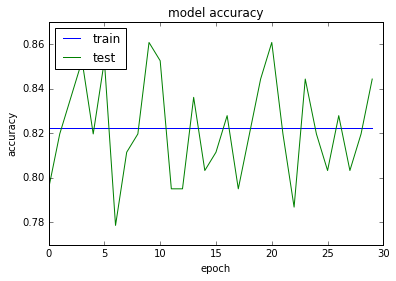

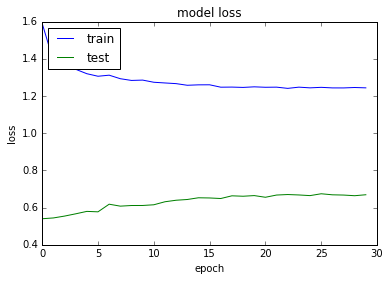

In [85]:
Model_evaluate(model,X_test,y_test,batch_size,history)